<a href="https://colab.research.google.com/github/sam-zlota/geometric-hashing/blob/main/Geometric_Hashing_Demo_04_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Geometric Hashing



## **Problem:** 
Given two point clouds, can we estimate the geometric transformation without any known correspondences? 

## **Applications** 
Many localization, recognition, and calibration tasks require registrations. Many computer vision tasks assume/require a calibrated camera. But, this is not always the case. Espeically with PTZ cameras where the parameters can change on the fly. Even with standard pin-hole cameras 

## **Considerations**


*   ***Degrees of freedom, complexity of transformation***
    - Small rigid transformations can be quite intuitive to solve and understand. Sometimes, however, the model and the image can be quite disparate in scale. Full camera transformations can have many degrees of freedom mapping 3D world landmarks to 2d image points of interest. Algorithms like ICP assume you have some overlap in your world and model, bu this is not always the case for large, complex transformations.
*   ***Perturbations***
    - Sensor measurements can be noisy and perturbed. 
*   ***False Negatives / False Positives (Occlusion, Noisy Sensor)***
    - Often our sensor readings can have extra points due to bad detections or noise. Similarly, sensors can be occluded and thus sensor readings can have missing points from the model. 
*   ***Strucutre/Regularity/Self-Similarity***
    - Because ICP does not take shape or geoentry into account, this is not a factor or ICP. However, Geometric Hashing exploits local geoemtric features to localize substructures in point clouds. Thus, if there is some similarity within a point cloud or any sort of regularity, geometric hashing may get confused.
*   ***Dimensionality***
    - The version of the algorithm explored here only works on 2D data. Many ICP algorithms work just fine on high dimensional data.
*   ***Size***
    - The offline stage of the Geometric Hashing algortihm is combinatorial, so it approaches factorial complexity in the size of the model. For data like stars where there are potentially millions of data, the runtime may be prohibitively expensive.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform
from tqdm import tqdm
from scipy.spatial import KDTree
import cv2
from itertools import combinations, permutations
from sklearn.neighbors import NearestNeighbors

## ICP implementation 
taken from https://github.com/ClayFlannigan/icp/blob/master/test.py

This will be used for comparison purposes


In [ ]:
#@title Click to see ICP code
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

##Utilility Functions

In [ ]:
def rand_affine_trans(scale_low = 0.5, scale_high = 1.5, rot_low = 0, rot_high = np.pi/10, trans_low = -2, trans_high = 2, shear_low = 2, shear_high = np.pi/10 ):
    """
    Produces a random affine transformation within the specified bounds. 
    
    This function can be used to represent all geometric transformations up to and including Affine Transformations. Affine 
    transformations are quite powerful and can represent 6 degres of freedom. The most complex 2D transformations, 
    projective trasnformations, have 8 degrees of freedom. In many casses affine transformations can robustly model
    projective transformations.

    """
    return AffineTransform(scale=np.random.uniform(low=scale_low, high=scale_high),
                        rotation=np.random.uniform(low=rot_low, high=rot_high),
                        translation=np.random.uniform(low=trans_low, high=trans_high, size=(1,2)),
                        shear=np.random.uniform(low=shear_low, high=shear_high))
    
def solve_affine_transformation(src, dst):
    """
    Estimates the best 2D affine transformation between the source and destination points. 
    """
    mat,_ = cv2.estimateAffine2D(src, dst) 
    mat = np.vstack((mat, [0,0,1]))
    return AffineTransform(matrix=mat)


def is_invertible(a):
     return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

     

#Geometric Hashing Algorithm Implementation

In [ ]:
def geohash(A,B,C,D):
    """
    Computes the affine invariant coordinates of point D with respect to
    affine basis (triangle) formed by points A,B,C.  

    Every 2D affine basis can encode any point that does not lie on the triangle
    in an affine invariant way. Any affine transformation (translation, scale,
    shear, rotation) applied to all points A,B,C,D will preserve the affine
    invariant coordinates x,y.

    Thus we have a geometric hash, the heart of this algorithm. 
    """
    try:
      return np.linalg.solve(np.array([B-A, C-A]), np.array([D-A]).T)
    except Exception:
      return np.array([0,0])


###Offline Stage

In [ ]:
def offline_stage(points):
    """

    For each triplet of points, (A,B,C), that form an affine basis (are not collinear), for
    every other point D, compute the affine-invariant geoemtric hash (x,y) of D with respect to (A,B,C).

    Builds a table, stored as dictionary, where the keys are the geometric hash
    and the values are the points (A,B,C,D) used to compute the hash as described
    above.

    To enable sub-linear queries during online inference, the keys of the dictionary
    are copied into a KD-Tree.

    """

    num_points = len(points)

    # nPr formula to calculate the number of rows in the table
    num_rows = np.math.factorial(num_points)/np.math.factorial(num_points-4)

    table = {}
    with tqdm(total=num_rows) as pbar:
      for a,b,c,d in permutations(points, 4):
          pbar.update(1)
          x,y = geohash(a,b,c,d)
          x, y = float(x),float(y)
          table[(x,y)] = [a,b,c,d]

    tree = KDTree(list(table.keys()))
    return table, tree


###Online Stage


In [ ]:
from scipy.spatial import distance_matrix

def online_stage(table, tree, original_points, scene_points, err_thresh=0.001, max_iters=10_000):
    """

    The online inference of this stage takes some scene/image/sensor reading point 
    cloud that is assumed to differ approximately by an affine transformation.

    In a similar way that the hash table was built during the offline stage for 
    the model points, we enumerate all affine bases and compute hashes for every 
    other point. The difference here is that we stop once we find a match, so
    the runtime is constant with the query time of the table and is only really
    affected by noise. In essence, without any noise, this algorithm is provably
    correct and would only have to check one candidate.


    After calculating the geoemtric hash of some point with respect to some
    affine basis in the scene, we query the table with the model points. We use
    Nearest Neighbor Search with a KD-Tree to be robust to noise. Any noise may
    result in slightly off calcualtions, so a Nearest Neighbor search is robust 
    to that. Similarly, a Nearest Neighbor search is robust to any structural
    similarity in the model. For example, a model with many repeat substrcutures
    may require the algorithm to check multiple candidates.

    After querying the table, we have found a correspeondece. The scene points we are
    operating on in the current step of the algorithm must correspond with the model points
    that have the same geometric hash in the table computed offline. 

    Specifically, we have 3 points in the model and 3 points in the scene that 
    probably correspond to one another. Solving for the geoemtric transformation
    is now trivial. 


    For a sanity check, after computing the transformation between the model
    and the scene, we can re-map the entire model onto the scene (or vice versa)
    and calculate the error between the re-mapped points and the scene points.
    If the error is sufficiently low, we can be confident we have found an optimal
    correspondce and transformation.

    This functionr returns the transformation once it is found. 
     
    """

    same_size = len(scene_points) == len(original_points)
    num_points = len(scene_points)
    num_rows = np.math.factorial(num_points)/np.math.factorial(num_points-4)
    num_iters = 0
    with tqdm(total=num_rows) as pbar:
      for a,b,c,d in permutations(scene_points, 4):
          pbar.update(1)
          num_iters+=1
          if num_iters >= max_iters:
            print("FAILED")
            return None
          x,y = geohash(a,b,c,d)

          d, i = tree.query((float(x),float(y)), k=10)
          nearest_neighbors = tree.data[i]
          for nnx, nny in nearest_neighbors:
              ap, bp, cp, _ = table[(nnx,nny)]
              
              try:
                t = solve_affine_transformation(np.float32([a,b,c]),
                                              np.float32([ap,bp,cp]))
            
                if not is_invertible(t.params):
                  continue

                recovered_points = t.inverse(original_points)
              except Exception:
                continue

              if same_size:
                err = np.sqrt(np.sum(np.power(scene_points-recovered_points, 2)))
                if err < err_thresh:
                  return t
              else:
                err = np.median(np.min(distance_matrix(scene_points, recovered_points), axis=1))
                if err < 0.01:
                  return t
        

In [ ]:
def run_experiment(original_points, transformed_points, num_points_to_drop=0, num_points_to_add=0):

  """
  Experiment script to compare geometric hashing to ICP on some sample scenario
  """

  transformed_point_indices_to_drop = np.random.choice(len(transformed_points), num_points_to_drop, replace=False)

  transformed_point_indices_to_keep = \
  [i for i in np.arange(len(transformed_points)) if i not in transformed_point_indices_to_drop]

  transformed_points_to_keep = transformed_points[transformed_point_indices_to_keep]

  additional_points = []

  for _ in range(num_points_to_add):
    x_min= transformed_points[:, 0].min()
    y_min= transformed_points[:, 1].min()
    x_max = transformed_points[:, 0].max()
    y_max= transformed_points[:, 1].max()
    x = np.random.uniform(x_min, x_max)
    y = np.random.uniform(y_min, y_max)
    additional_points.append((x,y))

  additional_points = np.array(additional_points)
  if num_points_to_add:
    transformed_points_to_keep = np.concatenate((transformed_points_to_keep, additional_points))

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

  ax1.scatter(original_points[:,0], original_points[:,1], s=100, label='model')
  ax1.scatter(transformed_points[:,0], transformed_points[:,1], label='observation')


  for (x1,y1), (x2,y2) in zip(original_points,transformed_points):
      ax1.plot([x1,x2],[y1,y2], color='black', lw=0.5)


  if num_points_to_drop:
    ax1.scatter(transformed_points[transformed_point_indices_to_drop,0],
                transformed_points[transformed_point_indices_to_drop,1],
                label='dropped', color='red', marker='x', s=200)
  if num_points_to_add:
    ax1.scatter(additional_points[:,0], additional_points[:,1], label='added', color='lime', s= 100)

  ax1.legend()
  ax1.set_title("Visualizing Transformation")

  print("Starting Offline Stage of GeoHash Algo")
  original_hash_table,  kdtree = offline_stage(original_points)

  print("Starting Online Stage of GeoHash Algo")

  recovered_t = online_stage(original_hash_table, kdtree, original_points, transformed_points_to_keep)
  if recovered_t is None:
    print("GEOMETRIC HASHING ALGORITHM FAILED")
    geohash_err = np.inf
  else:
    recovered_points = recovered_t(transformed_points)
    geohash_err = np.sum(np.linalg.norm(recovered_points-original_points))
    ax2.scatter(original_points[:,0], original_points[:,1], s=100, label='model')

    ax2.scatter(transformed_points[:,0], transformed_points[:,1], label='observation')
    ax2.scatter(recovered_points[:,0], recovered_points[:,1], color='magenta', label='recovered')

  
  ax2.set_title(f"Visualizing Geometric Hashing Results (SSD= {round(geohash_err, 6)})")


  ax2.legend()

  if num_points_to_drop == 0 and num_points_to_add == 0:

    print("Running ICP Algo")
    ICP_T, distances, iterations = icp( transformed_points_to_keep, original_points, tolerance=0.000000001 )

    ICP_RECOVERED = np.ones((len(transformed_points_to_keep),3))
    ICP_RECOVERED[:,0:2] = np.copy(transformed_points)

    ICP_RECOVERED = np.dot(ICP_T, ICP_RECOVERED.T).T
    icp_err = np.linalg.norm(ICP_RECOVERED[:,:2]-original_points)


    ax3.scatter(original_points[:,0], original_points[:,1], s=100, label='model')
    ax3.scatter(transformed_points[:,0], transformed_points[:,1], label='observation')
    ax3.scatter(ICP_RECOVERED[:,0], ICP_RECOVERED[:,1], color='red', label='recovered')
    ax3.set_title(f"Visualizing ICP Results (SSD= {round(icp_err, 6)})")

    ax3.legend()
  print("Done")
  plt.show()

  

#Experiments




### **Experiment 1:**  Simple Rigid Transformation with small translation right and rotation 15 degrees on synthetic, random, unstructured data


Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:07<00:00, 15601.86it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 308/116280.0 [00:02<14:58, 129.01it/s]


Running ICP Algo
Done


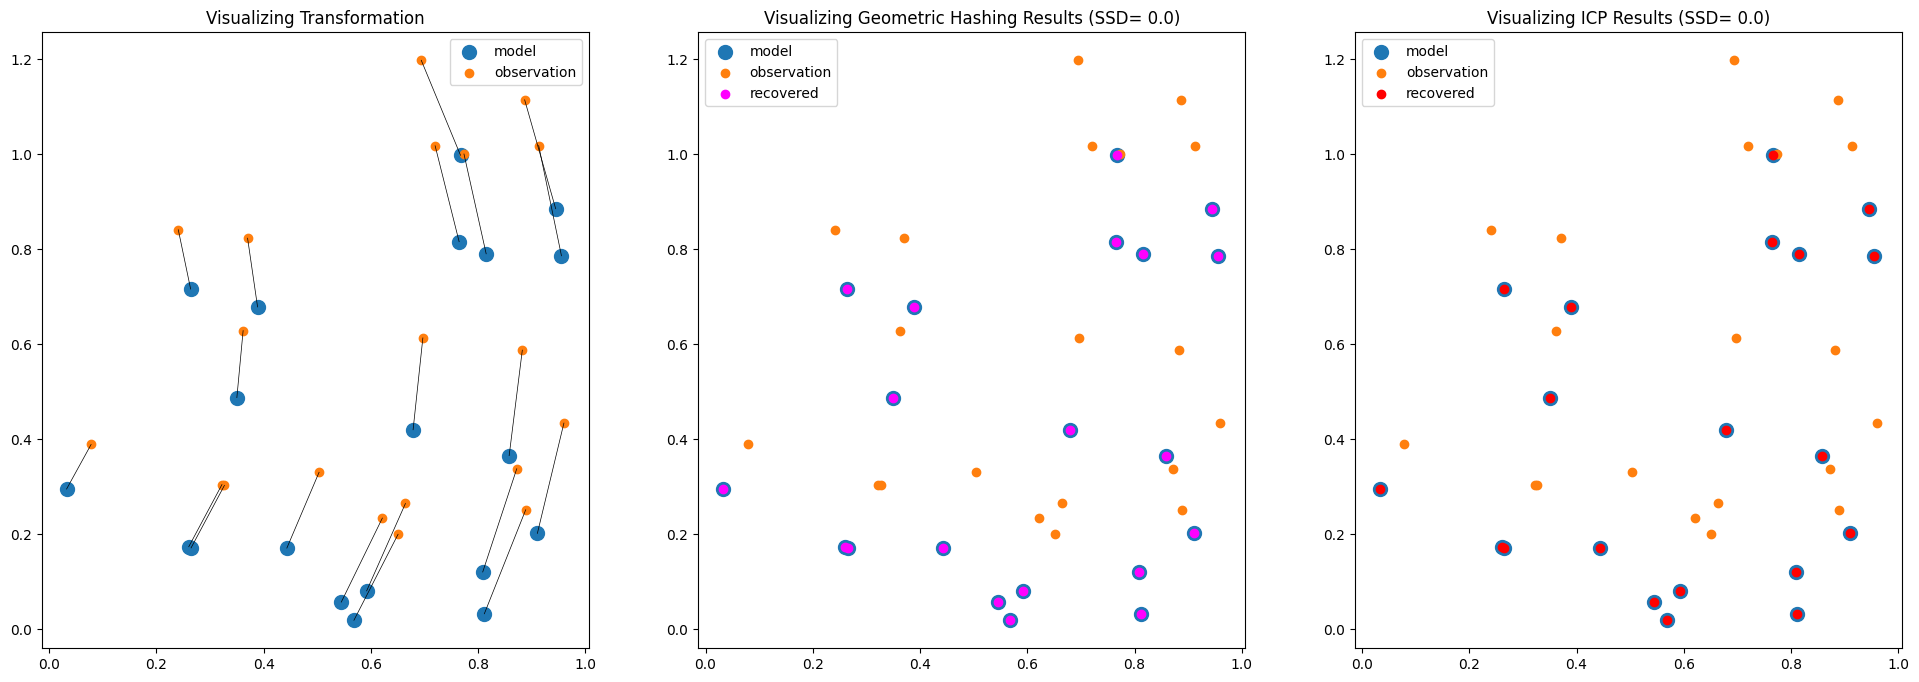

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height) /10

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi/20, rot_high = np.pi/20, shear_low = 0, shear_high = 0, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points)


### **Experiment 2:**  Simple Rigid Transformation with large translation right and rotation 180 degrees on synthetic, random, unstructured data

A simple transformation like rotation 180 degrees is enough to fool ICP, but geometric hashing is robust enough to recover the transformation.

Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:02<00:00, 48641.70it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 1/116280.0 [00:00<06:19, 306.18it/s]


Running ICP Algo
Done


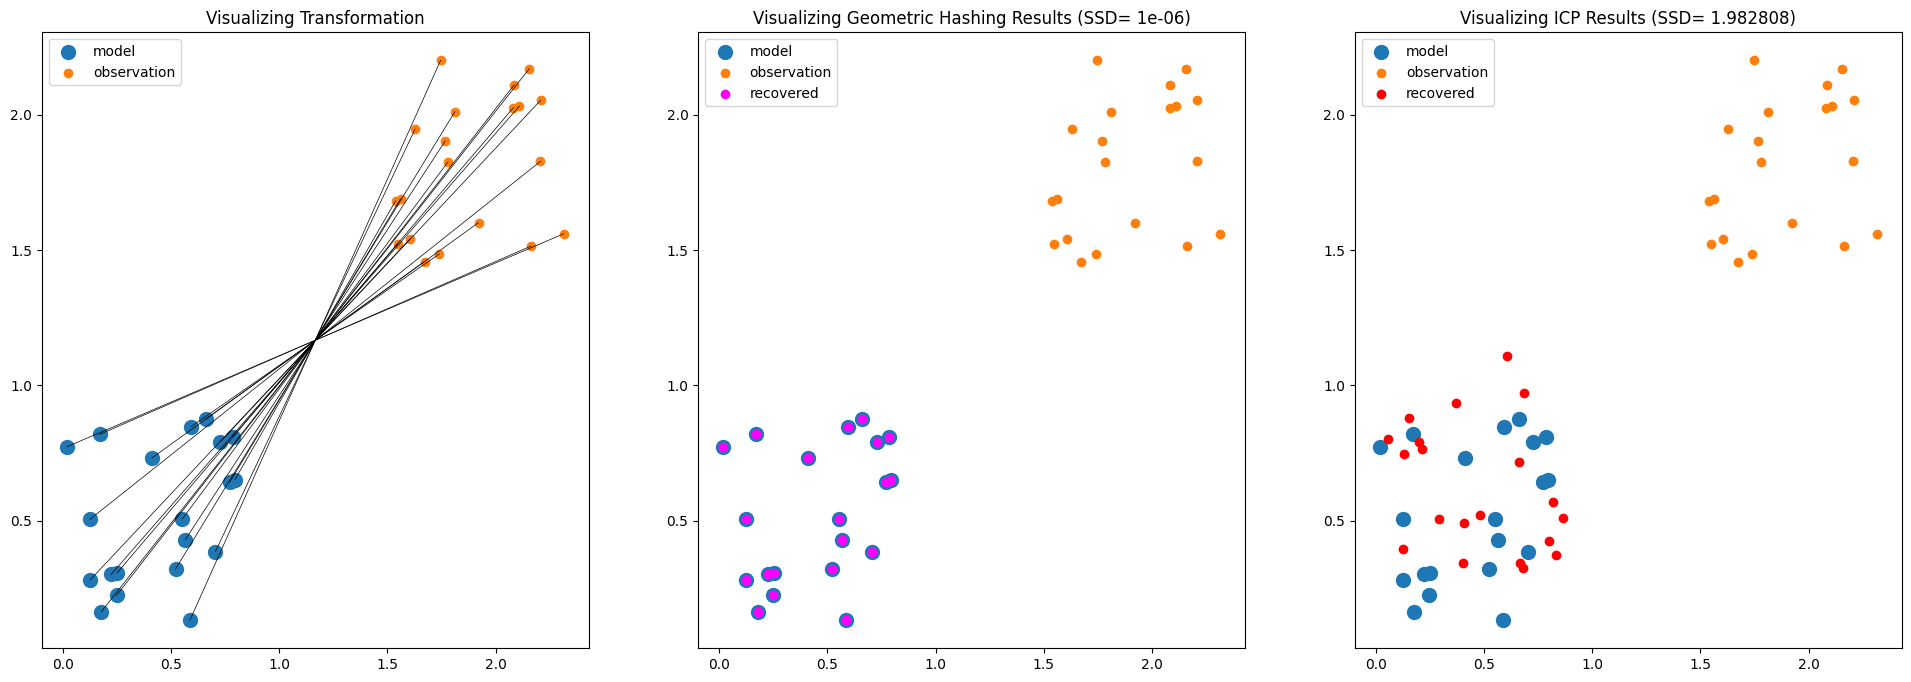

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = max(width, height)  * 3

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi, rot_high = np.pi, shear_low = 0, shear_high = 0, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points)


## Large N with small transformation
Geometric Hashing online inference is likely to underperform on dense data because the verification stage uses a distance based metric so two points may be close together and appear to correspond when in fact they do not. Additionally, this experiment demonstrates the combinatorial complexity of the offline stage wherein N doubles but the offline stage of the algortihm goes up by 5x. 

Starting Offline Stage of GeoHash Algo


100%|██████████| 2193360/2193360.0 [00:50<00:00, 43436.01it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 90/2193360.0 [00:00<1:52:53, 323.81it/s]


Running ICP Algo
Done


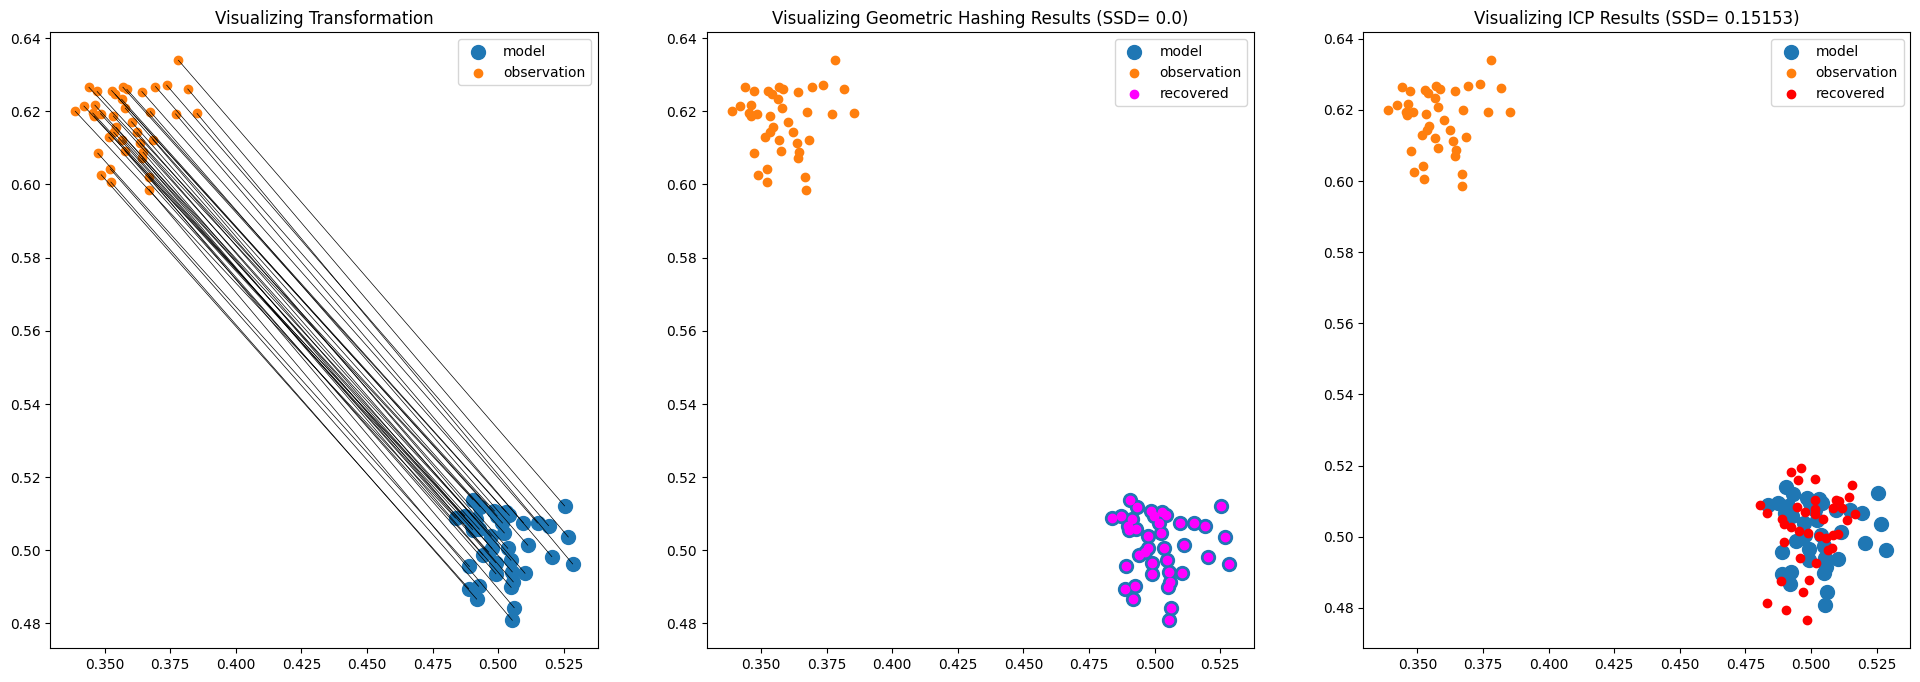

In [ ]:
N = 40
original_points = np.random.normal(0.5, 0.01, size=(N,2))
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height)/10

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points)


## Adding Small Perturbations

The expectation here is that Geoemtric Hashing will not be robust to sufficiently high perturbation noise because it is hard to exploit geometric invariance under strctural changes. ICP should be more robust because it is based on proximity and correspondence more so than structure matching.

The results indicate that Geometric Hashing is robust to sufficiently small perturbations, but after a certain point it fails and ICP prevails. 

Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:03<00:00, 35567.46it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 97/116280.0 [00:00<07:39, 253.04it/s]


Running ICP Algo
Done


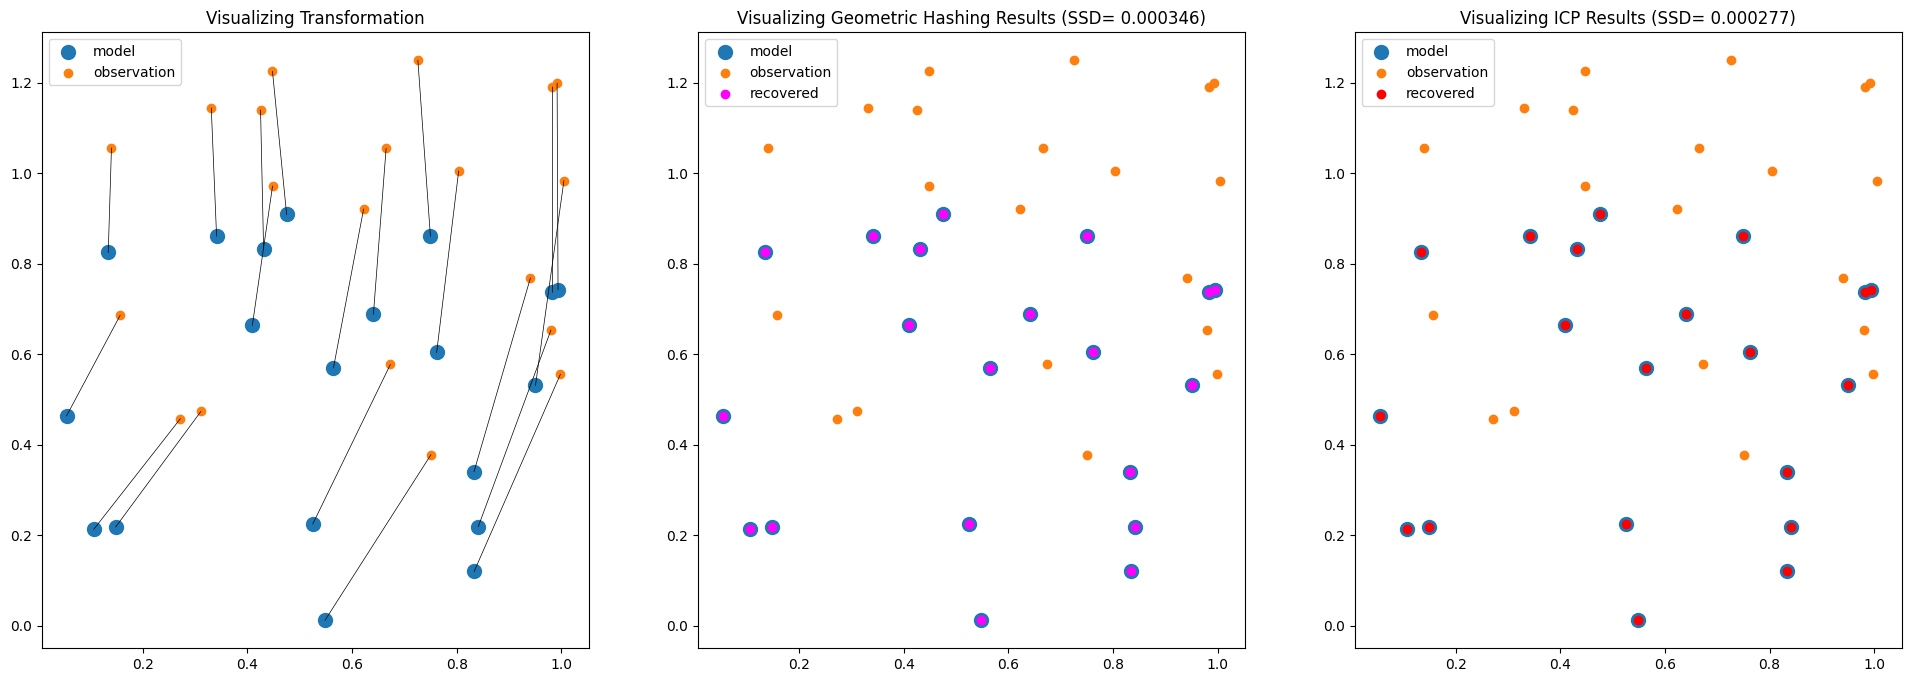

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height) /4

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points) + np.random.uniform(low=-1e-4, high= 1e-4, size=(N,2))

run_experiment(original_points, transformed_points)


## Adding Larger Perturbations

This experiment demonstrates that perturbation noise in the range of +/- 1e-3 is sufficent to throw off Geoemtric Hashing, even though it was robust to perturbations in the range +/- 1e-4. It is important to keep in mind that all demosntrations thus far have kept points within the unit square.

Noe that I have coded the algorithm to stop online inference after 10,000 iterations. 

Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:05<00:00, 20613.41it/s]


Starting Online Stage of GeoHash Algo


  9%|▊         | 10000/116280.0 [00:34<06:11, 285.90it/s]


FAILED
GEOMETRIC HASHING ALGORITHM FAILED
Running ICP Algo
Done


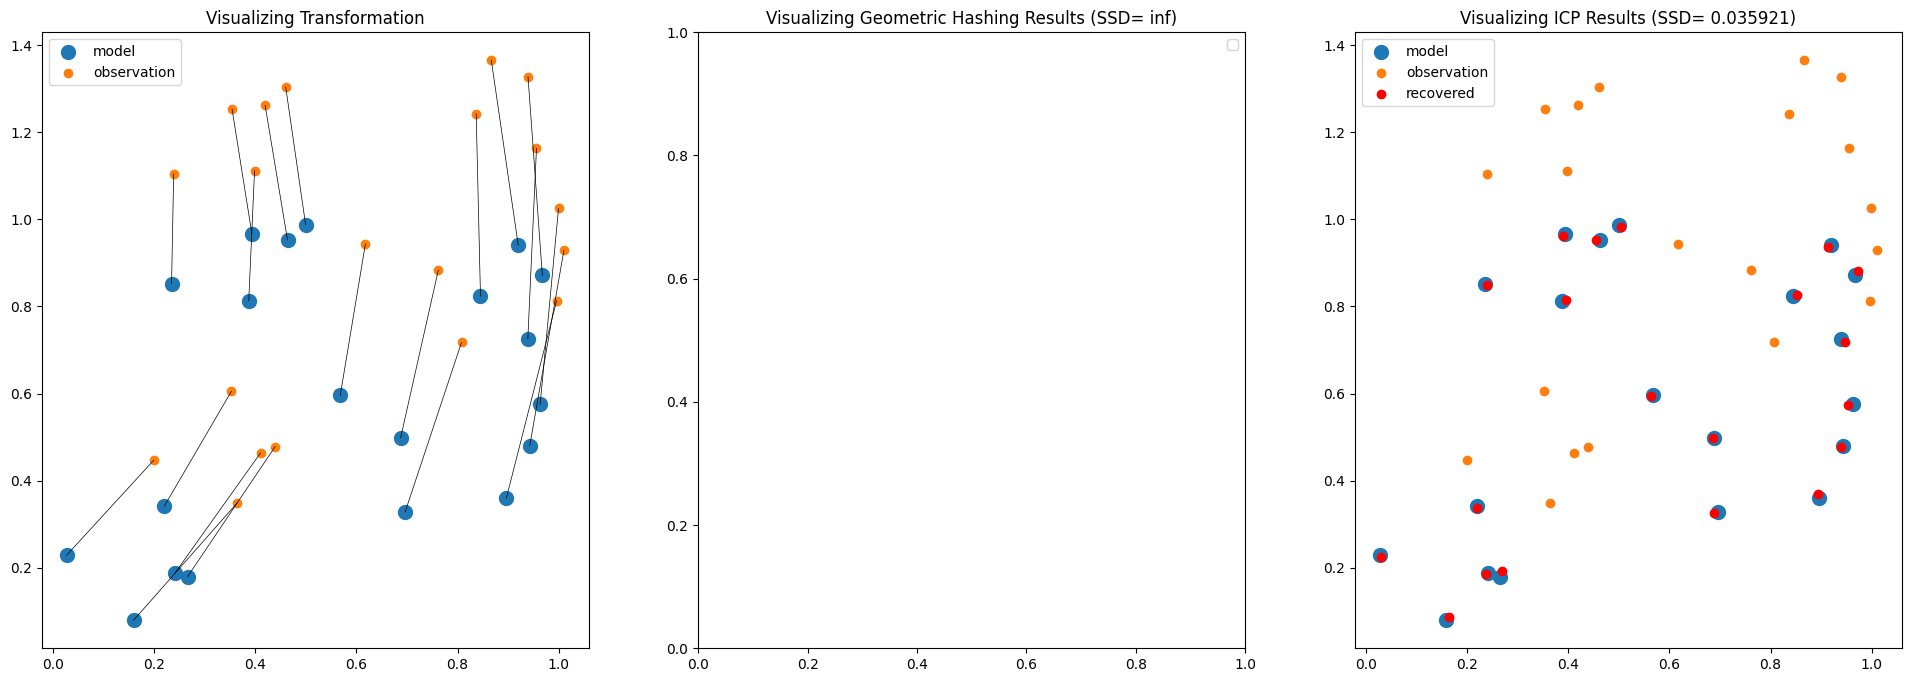

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height) /4

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points) + np.random.uniform(low=-1e-2, high= 1e-2, size=(N,2))

run_experiment(original_points, transformed_points)


## Incorporating more complex trasnformations like shearing, scale

This variation of geoemtric hashing is invariant to affine transformations which include more than just rotation and translation. It is expected that ICP will fail on these extra transformations.

Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:02<00:00, 41234.21it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 426/116280.0 [00:01<05:48, 332.07it/s]


Running ICP Algo
Done


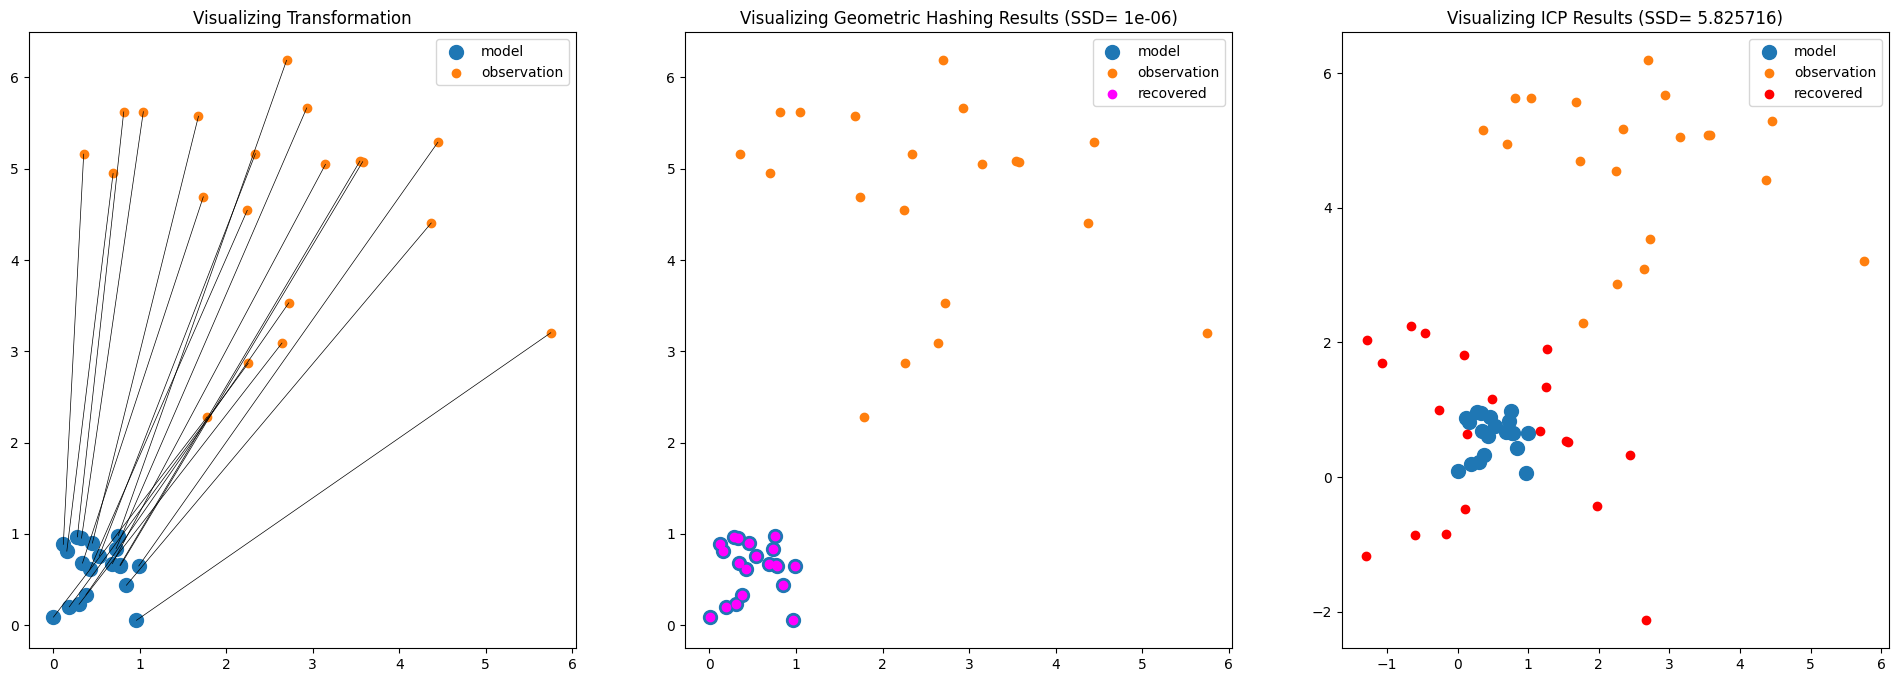

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = max(width, height) * 2

transform = rand_affine_trans(scale_low=0.2, scale_high=5, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 1.5, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points)

## Random drop-out (false negatives)

Sensor readings from camera and lidar are very suceptible to false negative detections. Occlusion and other confounding factors are very common in real world data. Geoemtric Hashing exploits substrctures, so it is expected to be quite robust to occlusion. However, this implementation of ICP expects the two points that are being registered to have the same number of points, so we cannot run it.

Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:02<00:00, 51583.57it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 119/32760.0 [00:00<01:52, 290.19it/s]


Done


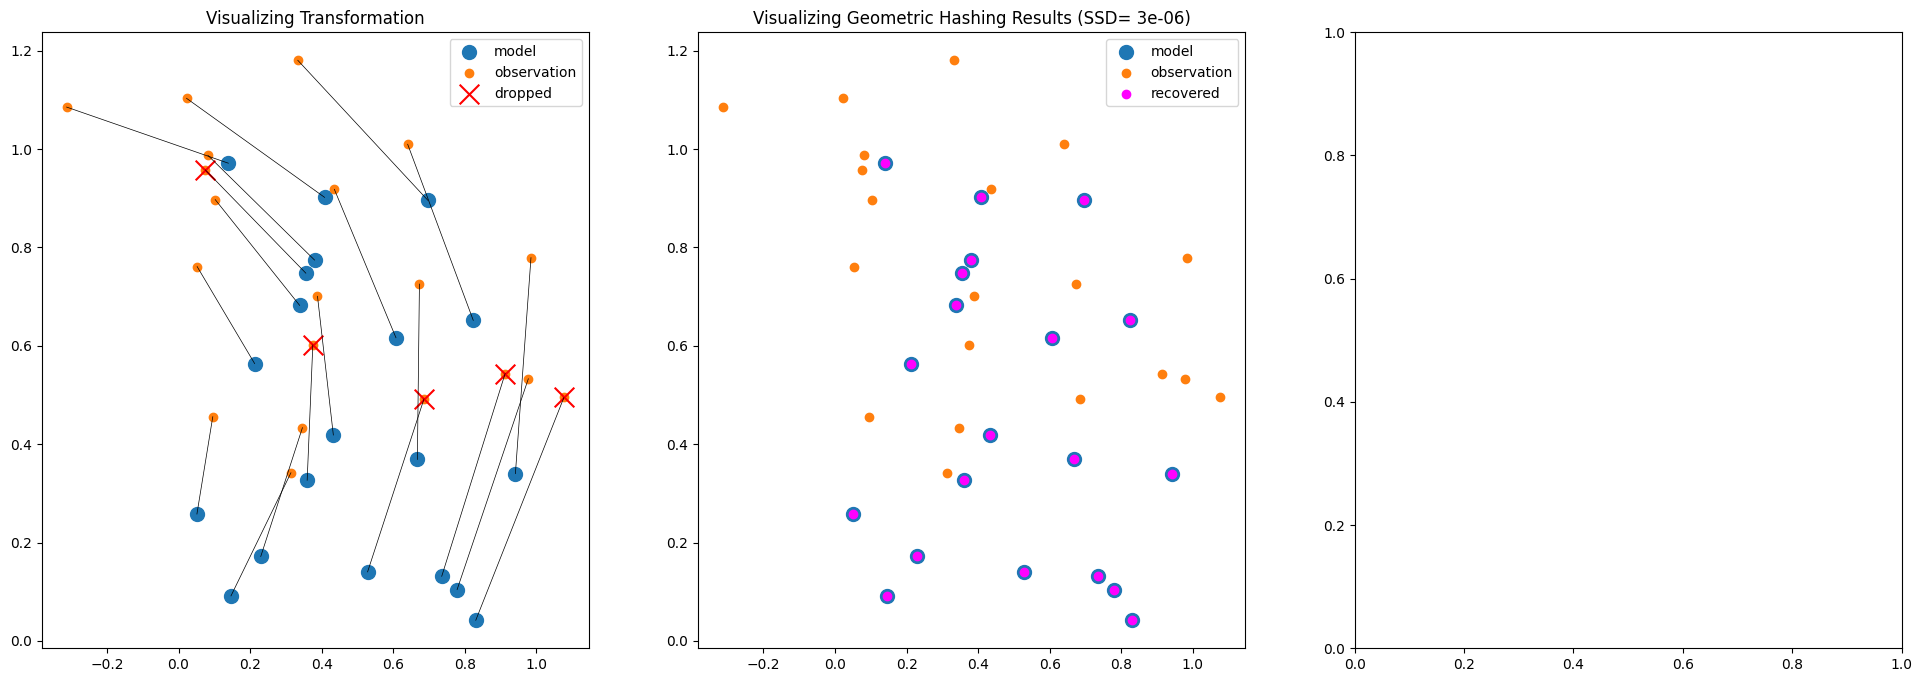

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height) /4

transform = rand_affine_trans(scale_low=0.8, scale_high=1.2, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0.5, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points, num_points_to_drop = 5)

## Adding Random New Points (false positive detections)
In a similar way that real world data has false negatives it to has false positives. For example, when capturing photography of the night sky there are many bright points in the sky that are indistinguishable from stars like statelites or aircraft. Geoemtric hashing is expected to be robust to sufficiently small false positives as well. 

[[0.97004652 0.93455175]
 [0.86294074 0.92986578]
 [0.52020984 0.39408296]
 [0.10976689 0.3778819 ]
 [0.84962531 0.64513989]]
Starting Offline Stage of GeoHash Algo


100%|██████████| 116280/116280.0 [00:02<00:00, 51682.72it/s]


Starting Online Stage of GeoHash Algo


  0%|          | 58/303600.0 [00:00<20:07, 251.45it/s]


Done


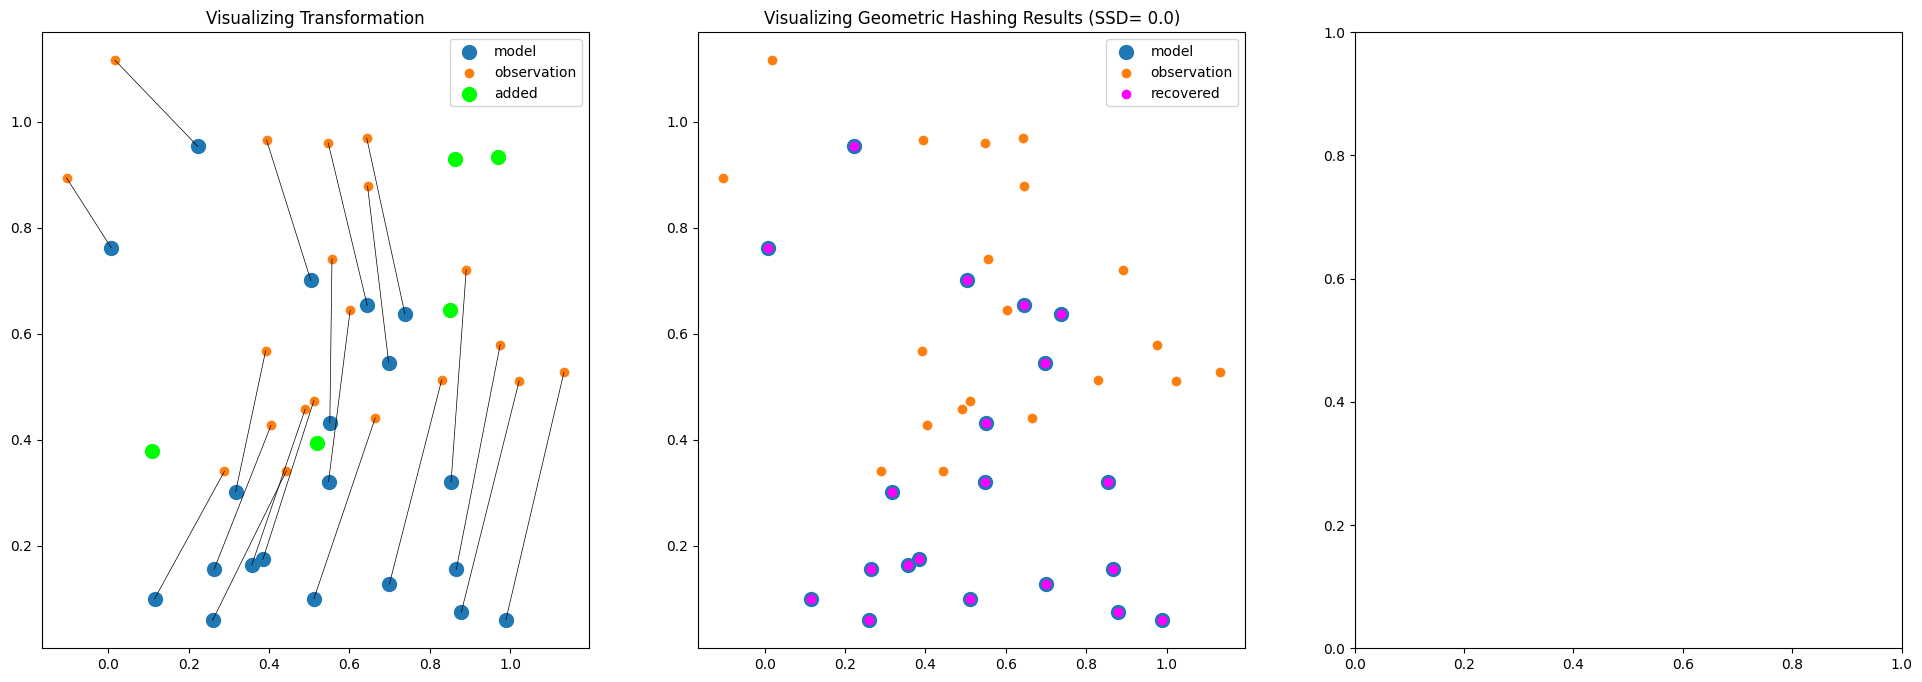

In [ ]:
N = 20
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = min(width, height) /4

transform = rand_affine_trans(scale_low=0.8, scale_high=1.2, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0.5, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points, num_points_to_add=5)

putting it all together noise model

In [ ]:
N = 50
original_points = np.random.rand(N,2)
width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = max(width, height) * 2

transform = rand_affine_trans(scale_low=0.2, scale_high=5, rot_low = np.pi/12, rot_high = np.pi/12, shear_low = 0, shear_high = 0.5, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points, num_points_to_add = 2, num_points_to_drop = 2)

structured and regular data

Starting Offline Stage of GeoHash Algo


100%|██████████| 303600/303600.0 [00:05<00:00, 51506.78it/s]


Starting Online Stage of GeoHash Algo


  2%|▏         | 7005/303600.0 [00:24<17:35, 281.07it/s]


Running ICP Algo
Done


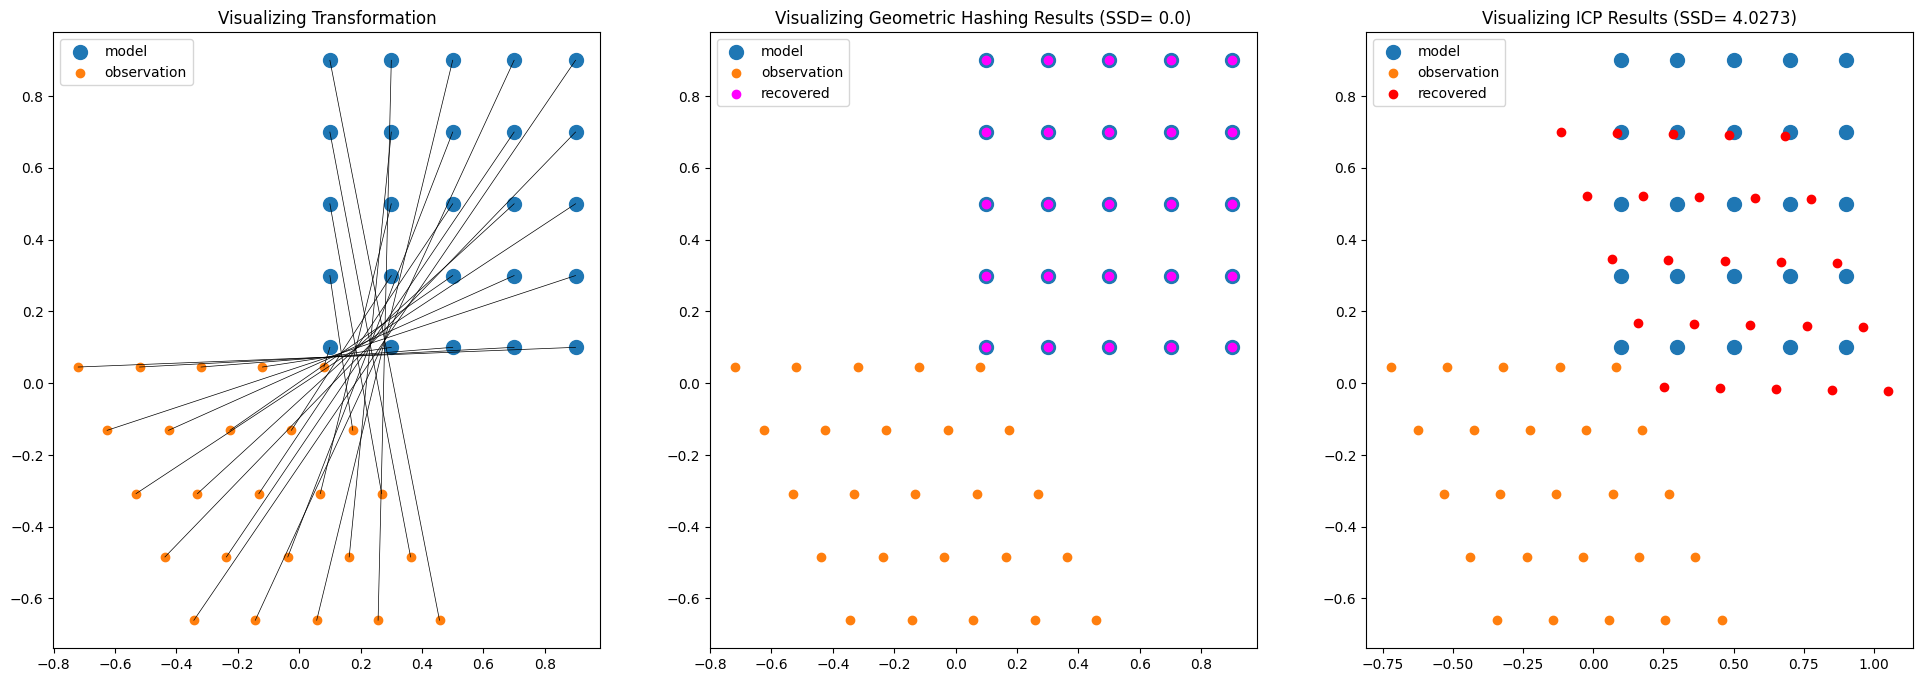

In [ ]:
from itertools import product
original_points = np.array(list(product(np.linspace(0.1,0.9,5), np.linspace(0.1,0.9,5))))

width = original_points[:,0].max() -  original_points[:,0].min()
height = original_points[:,1].max() -  original_points[:,1].min()
translation = max(width, height) /6

original_points = original_points 

transform = rand_affine_trans(scale_low=1, scale_high=1, rot_low = np.pi, rot_high = np.pi, shear_low = 0, shear_high = 1.2, trans_low=translation, trans_high=translation)
transformed_points = transform(original_points)

run_experiment(original_points, transformed_points)

